In [8]:
import numpy as np
import matplotlib.pyplot as plt
from fears.population import Population
from fears.utils import plotter
import scipy
import seaborn as sns
from matplotlib.colors import ListedColormap

In [9]:
def indx_matrix_from_zero(indx,mat):

    ycenter = int(mat.shape[0]/2)
    xcenter = int(mat.shape[1]/2)

    y = indx[0] - ycenter
    x = indx[1] - xcenter
    val = mat[int(y),int(x)]

    return val

def twoD_eqn(umax,x,D_vessel=0.01):

    if x < D_vessel:
        u = umax
    else:
        u = umax*scipy.special.kn(0,x)
    return u

def oneD_eqn(umax,x):
    return umax*np.exp(-x)

def most_fit_at_conc(dc,pop):
    
    # for each point in the drug concentration curve, what is the most fit genotype
    mf = np.zeros(len(dc))

    for c in range(len(dc)):

        conc = dc[c]
        p_fit_list = pop.gen_fit_land(conc)
        mf[c] = (np.argmax(p_fit_list))
    
    return mf

def detect_changes(mf):
    
    x = 0
    chunks = []

    last_most_fit = mf[0]
    new_chunk = False
    left_indx = 0

    while x < len(mf):
        cur_most_fit = mf[x]
        if last_most_fit != cur_most_fit:

            right_indx = x
            chunks.append((left_indx,right_indx))
            left_indx = x

        x+=1
        last_most_fit = cur_most_fit
    
    chunks.append((right_indx,len(mf)))
    
    return chunks

def plot_drug_curve(ax,dc,mf,chunks,colors_t,pop,x=None,**kwargs):
    
    n = 0
    for chunk in chunks:
        if x is None:
            x_t = np.arange(chunk[0],chunk[1])
        else:
            x_t = x[chunk[0]:chunk[1]]
        dc_t = dc[chunk[0]:chunk[1]]

        most_fit = mf[chunk[0]]
        color = colors_t[int(most_fit)]
        l = pop.int_to_binary(int(most_fit))
        ax.plot(x_t,dc_t,color=color,label=l,**kwargs)
        n+=1
    
    return ax

def plot_msw_vspan(ax,mf,chunks,colors_t,pop,x=None,**kwargs):
    
    n = 0
    for chunk in chunks:
        if x is None:
            x_t = np.arange(chunk[0],chunk[1])
        else:
            x_t = x[chunk[0]:chunk[1]]

        most_fit = mf[chunk[0]]
        color = colors_t[int(most_fit)]
        l = pop.int_to_binary(int(most_fit))
        ax.axvspan(x_t[0],x_t[-1],color=color,label=l,**kwargs)
        n+=1
    
    return ax

cmap = sns.color_palette("colorblind", as_cmap=True)[0:4]
cmap_msw = ListedColormap(cmap)

In [10]:
options = {'k_abs':.95,
    'k_elim':.00839,
    'max_dose':5,
    'n_timestep':10000,
    'timestep_scale':0.05,
    'fitness_data':'random',
    'curve_type':'pulsed',
    'prob_drop':.5,
    'n_allele':2
    }

drug_conc_range = [-4,4]
# p = Population(
#                death_rate=0.1,
#                drug_conc_range = drug_conc_range,
#                ic50_limits=[-2.5,3],
#                drugless_limits=[0.8,1.5],
#                **options)

p = Population(death_model=None,**options)
p.drugless_rates = [1.28949852, 1.14399848, 1.22802236, 0.93619847]
p.ic50 = [-0.49205992, 1.76224515,  1.39341393,  2.84653598]

ic50_rank = np.sort(p.ic50)
umax = 20

In [11]:
s = 2 # mm, i.e. a 2 mm patch of tissue
step = 0.01 # each pixel is 10 um x 10 um
D_vessel = 0.01 # vessel diameter is 10 um

xdim = np.arange(-s,s,step)
ydim = np.arange(-s,s,step)
uhat = np.zeros((np.size(xdim),np.size(xdim)))

u_distances = np.zeros((np.size(xdim),np.size(xdim))) # a matrix of the distance of each pixel from the origin

# Compute steady-state solution in radial coordinates
for i in range(np.size(xdim)):
    for j in range(np.size(xdim)):
        gamma = np.sqrt((xdim[i]**2) + ydim[j]**2)
        uhat[i,j] = twoD_eqn(umax,gamma,D_vessel=D_vessel)
        u_distances[i,j] = gamma
        # uhat[i,j] = steadystate((np.sqrt((xdim[i]**2) + ydim[j]**2)),k=100,D=6.45,r=.1)

uhat = umax*uhat/np.max(uhat) # normalize to umax

uhat[u_distances < D_vessel] = umax # make sure the interior of the vessel is umax

In [12]:
# Convolution

s_d = s

delta_array = np.zeros((np.size(xdim),np.size(xdim)))

delta_array[160,200] = 1
delta_array[240,200] = 1

# Convolve the steady state solution with the impulse matrix
conv = scipy.signal.convolve2d(delta_array,uhat,mode='same')#,mode='same',boundary='wrap')

conv = conv[:,1:] # weird boundary conditions
log10_conv = np.log10(conv)

In [13]:
most_fit_img = np.zeros(log10_conv.shape)

for z in range(log10_conv.shape[0]):
    for j in range(log10_conv.shape[1]):
        conc = 10**log10_conv[z,j]
        p_fit_list = p.gen_fit_land(conc)
        most_fit_img[z,j] = int((np.argmax(p_fit_list)))
        

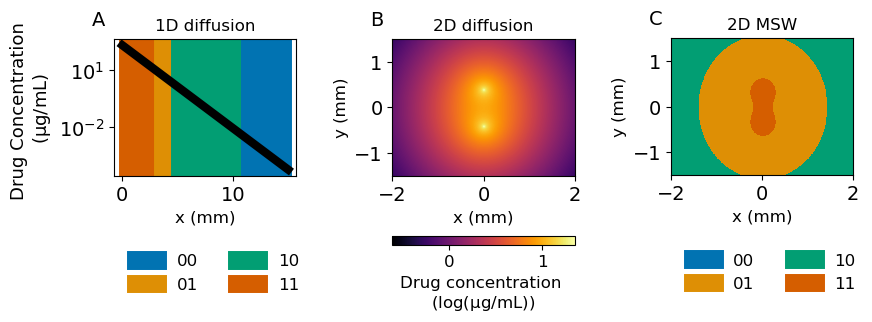

In [14]:
fig, ax_list = plt.subplots(ncols=3,figsize=(8, 6))

counts = np.zeros(p.n_genotype)

final_range_y = (-150,150)
final_range_x = (-200,200)

# ax = ax_list[1]

# imfit = ax_list[2].imshow(most_fit_img,cmap=cmap_msw,extent = [-s_d,s_d,-s_d,s_d],
#                      interpolation='gaussian',interpolation_stage='rgba',vmin=0,vmax=3)

imfit = ax_list[2].imshow(most_fit_img,cmap=cmap_msw,extent = [-s_d,s_d,-s_d,s_d],
                     interpolation='nearest',interpolation_stage='rgba',vmin=0,vmax=3)

# Plot 2D diffision
im = ax_list[1].imshow(log10_conv,cmap='inferno',extent = [-s_d,s_d,-s_d,s_d])

for a in ax_list:
    a.tick_params(axis='both', which='major', labelsize=14)

for a in ax_list[1:]:
    a.set_aspect('equal')


# Increase x spacing of axes

cb = fig.colorbar(im, ax=ax_list[1],location='bottom',pad=0.2)
cb.ax.tick_params(labelsize=12) 
cb.set_label('Drug concentration \n(log($\mathrm{\mu}$g/mL))',fontsize=12)

ax_list[1].set_ylim(-1.5,1.5)
ax_list[2].set_ylim(-1.5,1.5)

x = np.linspace(0,15,num=1000)

ic50_ranked = np.sort(p.ic50)
umax = 10**np.mean((ic50_ranked[-1],ic50_ranked[-2]))
dc = oneD_eqn(umax,x)
# diff = steadystate(x=x,k=100,D=6.45,r=.1)
#k in ug/ML
#D in 10^-6 cm^2/s

#now goal is to look at where conc space dominance and what is dominant where

def most_fit_at_conc(dc,pop):
    
    # for each point in the drug concentration curve, what is the most fit genotype
    mf = np.zeros(len(dc))

    for c in range(len(dc)):

        conc = dc[c]
        p_fit_list = pop.gen_fit_land(conc)
        mf[c] = (np.argmax(p_fit_list))
    
    return mf

mf = most_fit_at_conc(dc,p)
chunks = detect_changes(mf)

# cc = plotter.gen_color_cycler(style='solid',n_colors=4,palette='colorblind')
# cc_dict = cc.by_key()
# colors_t = cc_dict['color']

ax_list[0] = plot_msw_vspan(ax_list[0],mf,chunks,cmap,p,x=x,linewidth=5)
ax_list[0].plot(x,dc,linewidth=6,color='black')

# ax[1].set(xlabel='x ($10^{-3}$ cm)', ylabel='Drug Concentration (ug/ml)')
ax_list[0].set_xlabel(xlabel='x (mm)',fontsize=12)
ax_list[0].set_ylabel(ylabel='Drug Concentration \n($\mathrm{\mu}$g/mL)',fontsize=13)
ax_list[0].set_yscale('log')

# ax_list[0] = plotter.shiftx(ax_list[0],0.1)

# for a in ax:
#     a.tick_params(axis='both', which='major', labelsize=12)

handles, labels = ax_list[0].get_legend_handles_labels()

unique_labels = sorted(set(labels))
labels = np.array(labels)
unique_handles = []

for lab in unique_labels:
    indx = np.argwhere(labels==lab)
    indx = indx[0][0]
    unique_handles.append(handles[indx])

ax_list[0].legend(unique_handles,unique_labels,loc = (0.1,-0.7),frameon=False,
             fontsize=12,ncol=2)

pos1 = ax_list[1].get_position()
h = pos1.height

pos0 = ax_list[0].get_position()
pos0.y0 = pos1.y0

pos0.y1 = pos0.y0 + h
ax_list[0].set_position(pos0)

# shift ax[1] and ax[2] to the right
pos1 = ax_list[1].get_position()
w = pos1.width
pos1.x0 = pos0.x1 + 0.12
pos1.x1 = pos1.x0 + w
ax_list[1].set_position(pos1)
ax_list[1].set_xlabel('x (mm)',fontsize=12)
ax_list[1].set_ylabel('y (mm)',fontsize=12)

cb_pos = cb.ax.get_position()
cb_pos.x0 = pos1.x0
cb_pos.x1 = pos1.x1
cb_pos.y0 = pos1.y0 - 0.16
cb_pos.y1 = pos1.y0 - 0.1
cb.ax.set_position(cb_pos)

pos2 = ax_list[2].get_position()
pos2.x0 = pos1.x1 + 0.12
pos2.x1 = pos2.x0 + w
ax_list[2].set_position(pos2)
ax_list[2].set_xlabel('x (mm)',fontsize=12)
ax_list[2].set_ylabel('y (mm)',fontsize=12)


ax_list[0].legend(unique_handles,unique_labels,loc = (0.05,-0.9),frameon=False,
             fontsize=12,ncol=2)
ax_list[2].legend(unique_handles,unique_labels,loc = (0.05,-0.9),frameon=False,
             fontsize=12,ncol=2)

ax_list[0].set_title('1D diffusion',fontsize=12)
ax_list[1].set_title('2D diffusion',fontsize=12)
ax_list[2].set_title('2D MSW',fontsize=12)

ax_list[0].text(-0.12,1.1,'A',transform=ax_list[0].transAxes,fontsize=14)
ax_list[1].text(-0.12,1.1,'B',transform=ax_list[1].transAxes,fontsize=14)
ax_list[2].text(-0.12,1.1,'C',transform=ax_list[2].transAxes,fontsize=14)

fig.savefig('figures/steady_state_diffusion.pdf',bbox_inches='tight')